# Graph Agents
* The specific short project aims to combine the concepts of **multiagent systems** and **knowledge graphs**.
* A multiagent system consists of multiple artificial intelligence agents working collectively to perform tasks on behalf of a user or another system ([IBM](https://www.ibm.com/think/topics/multiagent-system)).
* A knowledge graph is an organized representation of real-world entities and their relationships. It is typically stored in a graph database, which natively stores the relationships between data entities ([Neo4j](https://neo4j.com/blog/what-is-knowledge-graph/)).
* The idea behind combining multiagent systems with knowledge graphs is to **enhance query answering** by leveraging the **agents' specialized reasoning capabilities** and the **knowledge graph's structured semantic relationships**, enabling more accurate, context-aware, and scalable solutions.
* The specific implementation consists of 3 steps:
    1. *Creation of the knowledge graph*: this is done with [GraphRAG](https://github.com/microsoft/graphrag).
    2. *Saving the graph in a database*: a [Neo4j](https://neo4j.com/) graph database is used.
    3. *Building the multiagent system for question answering*: using [AG2](https://github.com/ag2ai/ag2) (formerly AutoGen).

## Acknowledgements
* Three resources influenced the implementation:
    1. [GraphRag: Getting Started](https://microsoft.github.io/graphrag/get_started/)
    2. [Commit `cb0aae7` in GraphRAG](https://github.com/microsoft/graphrag/commit/cb0aae7e6bf1763ca5a7540d2220c11162863915)
    3. [Knowledge Graphs for RAG course by DeepLearning.AI](https://learn.deeplearning.ai/courses/knowledge-graphs-rag)

## 1. Creation of the knowledge graph
* GraphRAG calls this process [indexing](https://microsoft.github.io/graphrag/index/overview/).
* It is designed to:
    1. extract entities, relationships and claims from raw text
    2. perform community detection in entities
    3. generate community summaries and reports at multiple levels of granularity
    4. embed entities into a graph vector space
    5. embed text chunks into a textual vector space
* The process can be executed from the command line following the guidelines described in the [Getting Started](https://microsoft.github.io/graphrag/get_started/) page.


### Create the folder
* In this folder the indexing files will be saved.

In [1]:
import os

os.makedirs('./graph_agents_indexing/input', exist_ok=True)

### Download test data
* Download *Alice's Adventures in Wonderland* by Lewis Carrol (a personal favorite) from the [Gutenberg Project](https://www.gutenberg.org/).

In [2]:
!curl https://www.gutenberg.org/files/11/11-0.txt -o ./graph_agents_indexing/input/alice_in_wonderland.txt   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  150k  100  150k    0     0   117k      0  0:00:01  0:00:01 --:--:--  118k


### Initialize GraphRAG
* Setup GraphRAG.
* To do so follow the guidelines in the section [Set Up your Workspace Variables](https://microsoft.github.io/graphrag/get_started/#:~:text=Set%20Up%20Your%20Workspace%20Variables) of the *Getting Started* page.
* *Important*: Additionally set the `embeddings` value under `snapshots` to true, to get the embeddings of the entities.

In [3]:
!graphrag init --root ./graph_agents_indexing > NUL 2>&1

### Index data
* Run the indexing process

In [4]:
!graphrag index --root ./graph_agents_indexing > NUL 2>&1

* Now the results of the process are saved in parquet files within the `./graph_agents_indexing/output` folder.

## 2. Saving the graph in a database
* A powerful database option for graphs is [Neo4j](https://neo4j.com/).
* It uses nodes, relationships, and properties to represent and store data, enabling highly efficient querying and analysis of complex, interconnected information.
* The commit [`cb0aae7`](https://github.com/microsoft/graphrag/commit/cb0aae7e6bf1763ca5a7540d2220c11162863915) in GraphRAG was used as base for the `neo4j_loading.py` script.

### Neo4j installation (from [here](https://github.com/microsoft/graphrag/blob/1a13e0fd93cecca8b10eaa59860e5000d691d417/examples_notebooks/community_contrib/neo4j/graphrag_import_neo4j_cypher.ipynb#L19))
* You can create a free instance of Neo4j online. You get a credentials file that you can use for the connection credentials. You can also get an instance in any of the cloud marketplaces.
* If you want to install Neo4j locally either use Neo4j Desktop or the official Docker image: `docker run -e NEO4J_AUTH=neo4j/password -p 7687:7687 -p 7474:7474 neo4j`
* *Important*: To execute the cell below fill `neo4j_config.json` with your Neo4j credentials.

In [5]:
import json
import neo4j_loading
from neo4j import GraphDatabase

# load the Neo4j configuration
with open("neo4j_config.json") as f:
    config = json.load(f)

# create a Neo4j driver
driver = GraphDatabase.driver(config["uri"], auth=(config["username"], config["password"]))

neo4j_loading.load(driver)

Data loaded successfully.


## 3. Building the multiagent system for question answering
* [AG2](https://github.com/ag2ai/ag2) (formerly AutoGen) is a popular framework for building multiagent systems.
* First, we will set it up.
* *Important:* Fill the `openai_config.json` with your OpenAI credentials, as it is described [here](https://ag2ai.github.io/ag2/docs/topics/llm_configuration/). Additionally, similarly to the GPT model, create an item in the list of the embedding model, that will be used later (must include *embedding*) in the `model` value).



In [6]:
import autogen
import re
from typing import Dict, Union, List, Literal, Optional, Tuple

config_list = autogen.config_list_from_json(
    "openai_config.json",
)

llm_config={
        "cache_seed": 41,
        "config_list": config_list,
        "temperature": 0.4,
    }

### System Architecture
* The simple system will have the following architecture:

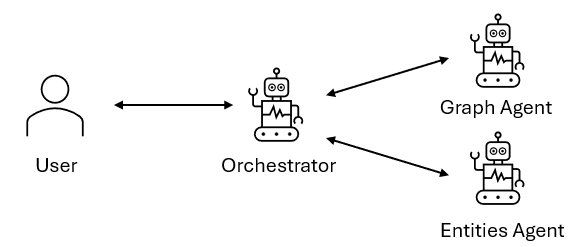

* The **Graph Agent** is responsible for querying the graph database to collect the necessary information.
* The **Entities Agent** identifies entities that are related to the given input.
* The **Orchestrator** interacts with the other two agents in order to collect the required information and return it to the user.

#### Graph Agent
* The Graph Agent takes the **database schema** and the **messages in the conversation** as input.
* It then **writes a [Cypher](https://neo4j.com/docs/getting-started/cypher/) query** and **executes** it.
* It returns the **output of the query** or the **exception raised**, alongside with the **suggested query**.
* To implement this logic, let's first extract the database schema.

In [7]:
def get_schema_formatted() -> str:
    """
    Get the schema of the graph in a clear format.
    """
    with driver.session() as session:
        # Get node labels and properties
        nodes_query = """
        MATCH (n)
        UNWIND labels(n) AS label
        RETURN label, collect(distinct keys(n)) AS properties
        """
        node_data = session.run(nodes_query).data()
        
        # Get example relationships (works for small graphs)
        example_relationships_query = """
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS from, type(r) AS relationship, labels(b) AS to
        LIMIT 100
        """
        relationship_examples = session.run(example_relationships_query).data()
    
    # Format node properties
    node_properties = []
    for node in node_data:
        label = node['label']
        properties = node['properties']
        # Flatten property keys and add example types (hardcoded for demo)
        formatted_properties = ", ".join([f"{key}: STRING" for key in sorted(set(k for p in properties for k in p))])
        node_properties.append(f"{label} {{{formatted_properties}}}")
    
    # Format relationships
    relationships = []
    for example in relationship_examples:
        from_labels = ":".join(example["from"])
        to_labels = ":".join(example["to"])
        relationship = example["relationship"]
        relationships.append(f"(:{from_labels})-[:{relationship}]->(:{to_labels})")
    
    # Combine into final schema format
    schema = f"""
Node properties: 
{", ".join(node_properties)}

Relationships:
{', '.join(relationships)}
"""
    return schema


schema = get_schema_formatted()
print(schema)


Node properties: 
__Entity__ {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Event {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Person {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Geo {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, Organization {description: STRING, embedding: STRING, human_readable_id: STRING, id: STRING, title: STRING}, __Community__ {community: STRING, full_content: STRING, level: STRING, rank: STRING, rank_explanation: STRING, summary: STRING, title: STRING}, Finding {explanation: STRING, id: STRING, summary: STRING}, __Document__ {id: STRING, title: STRING}, __Chunk__ {id: STRING, n_tokens: STRING, text: STRING}

Relationships:
(:__Community__)-[:HAS_FINDING]->(:Finding), (:__Chunk__)-[:PART_OF]->(:__Document__), (:__Chunk__)-[:HAS_ENTITY]->(:__Entity__:Person), (:__Ch

* The peculiarity of this agent is that it should not just write the Cypher script, but also **execute** it.
* To do this we will extend the `autogen.ConversableAgent`, and we will use the `register_reply` method to reply by generating a Cypher query, executing it, and return the result.

In [8]:
class GraphAgent(autogen.ConversableAgent):
    def __init__(
            self, 
            name: str,
            system_message: Union[str, List],
            llm_config: Union[Dict, Literal[False]] = None,
            **kwargs
            ) -> None:
        super().__init__(name=name, system_message=system_message, llm_config=llm_config, **kwargs)
        self.register_reply([autogen.Agent, None], GraphAgent.graph_reply)
    

    @staticmethod
    def _extract_cypher_block(text: str) -> str:
        """
        In case the cypher block is written inside ```cypher ... ```, extract the cypher query.

        Parameters:
            text (str): The text to extract the cypher query from.
        
        Returns:
            str: The extracted cypher query.
        """
        # regex pattern to match text within ```cypher ... ```
        pattern = r"```cypher(.*?)```"
        
        match = re.search(pattern, text, re.DOTALL)
        
        # if a match is found, return the matched text, else return the original text
        return match.group(1).strip() if match else text.strip()
    
    def graph_reply(self,
                           messages: Optional[List[Dict]] = None,
                           sender: Optional[autogen.agentchat.agent.Agent] = None,
                           config: Optional[autogen.oai.client.OpenAIWrapper] = None,
                           ) -> Tuple[bool, Union[str, Dict, None]]:
        """
        The custom reply method to generate a Cypher statement, query the database and return the result.

        Args:
            messages (Optional[List[Dict]]): A list of message dictionaries, where each message contains a "content" key
                                             with the text of the message. The latest message in the list is used to
                                             generate the query.
            sender (Optional[autogen.agentchat.agent.Agent]): The sender of the message, represented as an Agent object.
                                                              This parameter is not used in the function.
            config (Optional[autogen.oai.client.OpenAIWrapper]): A configuration object for interacting with an OpenAI
                                                                 model or service. This parameter is not used in the function.

        Returns:
            Tuple[bool, Union[str, Dict, None]]:
                - A boolean indicating success (always `True` in the current implementation).
                - A string containing the suggested query, and: 
                the result of the execution if it was successful, or the exception if it wasn't.
        """
        success, response = super().generate_oai_reply(messages, sender, config)

        if not success:
            return success, response

        # the cypher query to execute
        query = self._extract_cypher_block(response)

        # the response to return
        graph_response = "Suggested query:\n" + query + "\n"
        try:
            query_output = driver.execute_query(query)

            records_returned = ""
            for r in query_output.records:
                # if embeddings are returned, remove them from the response as they are too large
                if type(r) is dict:
                    key = r.keys()[0]
                    data = r.data()[key]
                    record = {key: {k: v for k, v in data.items() if k != "embedding"}}
                    records_returned += json.dumps(record, indent=4) + "\n"
                
                else:
                    records_returned += str(r) + "\n"

            return success, graph_response + "\nRecords Returned:\n" + records_returned
        except Exception as e:
            exception = str(e)
            return success, graph_response + "\nException raised:\n" + exception

* Next, we will craft a specialized prompt, that incorporates the schema of the database.

In [9]:
graph_prompt = f"""
You are a Graph Agent that generates Cypher statements to query a graph database.
Use the provided schema to query the database successfully.
Schema:
{schema}
You have to produce ONLY the Cypher query, as your response will be taken as is to query the database.
Be careful with the dashes in the names, the labels start and with double underscores (__), example: __Entity__.
*Note*: You don't have to answer the full query at once, you can collect information and then be asked again based on these.
**Important**: The titles are written with full capital letters.
"""

* Now, we are ready to create a graph agent.

In [10]:
graph_agent = GraphAgent(
    name="Graph_Agent",
    system_message=graph_prompt,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    )

#### Entities Agent
* The Entities Agent takes a query and identifies the **most related entities in the database** to the query.
* It does this using **embeddings**. Specifically, it maps the given query to a semantically reach vector, and compares it to the vector of the descriptions of each entity. It then returns the entities that are closer to the query (using cosine similarity).
* To implement this logic, we will create a `calculate_embedding` function.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from openai import AzureOpenAI, OpenAI

embedding_config = {}

# find the configuration for the embedding model
for model_config in config_list:
    if "embedding" in model_config["model"]:
        embedding_config = model_config
        break

if not embedding_config:
    raise ValueError("No embedding model found in the configuration.")

EMBEDDING_MODEL = embedding_config["model"]

# create the OpenAI client, either AzureOpenAI or OpenAI
if embedding_config.get("api_type", "openai") == "azure":
    OPENAI_CLIENT = AzureOpenAI(
        azure_endpoint=embedding_config["base_url"],
        api_key=embedding_config["api_key"],
        api_version=embedding_config["api_version"]
        )
else:
    OPENAI_CLIENT = OpenAI(
        api_key=embedding_config["api_key"],
        )


def calculate_embedding(text: str) -> List[float]:
    """
    Calculate the embedding for the given text.

    Parameters:
        text (str): The text to calculate the embedding for.
    Returns:
        List[float]: The calculated embedding.
    """
    return OPENAI_CLIENT.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding

* Next, we will create a `get_related_entities` function.
* It will get a piece of text as input and will return the most related entities in the database.
* To do this, the `embedding` field of each entity will be used.
* Before implementing the function, and to avoid querying the database every time, all the entities will be extracted.

In [12]:
results = driver.execute_query("""
    MATCH (e:__Entity__)
    RETURN e.id AS id, e.title AS title, e.description AS description, e.embedding AS embedding
""")

ALL_ENTITIES = []
for record in results[0]:
    entity = {
        "id": record["id"],
        "title": record["title"],
        "description": record["description"],
        "embedding": record["embedding"]
    }
    ALL_ENTITIES.append(entity)

len(ALL_ENTITIES)

161

In [13]:
def get_related_entities(query: str, top_k: int = 5) -> List[Dict]:
    """
    Get the most related entities to a query from the Neo4j database.

    Args:
        query (str): The user query.
        top_k (int): Number of top related entities to return.

    Returns:
        List of dictionaries with entity information and similarity scores.
    """
    # calculate the embedding for the query
    query_embedding = calculate_embedding(query)

    # compute similarity scores
    similarities = {}
    for i, entity in enumerate(ALL_ENTITIES):
        similarities[i] = cosine_similarity([query_embedding], [entity["embedding"]])[0][0]

    # sort entities by similarity and return top_k
    related_entities_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:top_k]
    related_entities = [ALL_ENTITIES[i] for i in related_entities_indices]

    return related_entities

* Let's see an example.

In [14]:
related_entities = get_related_entities("Who is the closest to Alice?")
for entity in related_entities:
    print(entity["title"])

ALICE
SISTER
ALICE'S LOVE
DINAH
RABBIT


* This agent doesn't even have to call an LLM, it must take the last query and return the related entities.
* To do this we will again extend the `autogen.ConversableAgent`, and we will use the `register_reply` method, to make the agent reply using the `get_related_entities` function.

In [15]:
class EntitiesAgent(autogen.ConversableAgent):
    def __init__(self, name: str, **kwargs) -> None:
        super().__init__(name=name, **kwargs)
        self.register_reply([autogen.Agent, None], EntitiesAgent.entities_reply)
    
    def entities_reply(self,
                       messages: Optional[List[Dict]] = None,
                       sender: Optional[autogen.agentchat.agent.Agent] = None,
                       config: Optional[autogen.oai.client.OpenAIWrapper] = None,
                       ) -> Tuple[bool, Union[str, Dict, None]]:
        """
        The reply function to register to the agent that returns the closest related entities to a query.

        Args:
            messages (Optional[List[Dict]]): A list of message dictionaries, where each message contains a "content" key
                                             with the text of the message. The latest message in the list is used to
                                             generate the query.
            sender (Optional[autogen.agentchat.agent.Agent]): The sender of the message, represented as an Agent object.
                                                              This parameter is not used in the function.
            config (Optional[autogen.oai.client.OpenAIWrapper]): A configuration object for interacting with an OpenAI
                                                                 model or service. This parameter is not used in the function.

        Returns:
            Tuple[bool, Union[str, Dict, None]]:
                - A boolean indicating success (always `True` in the current implementation).
                - A string containing a formatted response with the titles, and descriptions, of the
                  top related entities retrieved from the query.
        """
        query = messages[-1]["content"]
        similar_entities = get_related_entities(query, top_k=5)
        response = ""
        for i, entity in enumerate(similar_entities):
            response += f"Entity {i+1}:\nTitle: {entity['title']}\nDescription: {entity['description']}\n\n"
        return True, response
        

* We are now ready to initialize our Entities Agent.

In [16]:
entities_agent = EntitiesAgent(
    name="Entities_Agent",
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    )

#### Orchestrator Agent
* The Orchestrator is the **intermediate between the agents and the user**.
* It is an instance of the class `AssistantAgent` of autogen.
* We can write a prompt for this agent.

In [17]:
orchestrator_prompt = """
You are a helpful assistant, that interacts with a graph database to answer questions.
Two agents are available to help you:
1. Graph Agent: This agent generates Cypher statements to query the database. Call this agent when you have some information about what you are searching.
2. Entities Agent: This agent helps in finding similar entities in the database based on a query. Call this agent when you want to collect the name of the entities related to a specific query.

To interact with the agents, start your response with the agent's name.
Example format:
1. 'Graph Agent: What are the closest connections of ALICE?'
2. 'Entities Agent: Who are the main characters of the story?'

To complete the initial request, return the response to the user by starting with 'User:'
Example format:
'User: The closest connections of ALICE are ...'

**Important** if you are not satisfied wtih the answer of the graph agent, you can ask for more information.
"""

* And we are ready to initialize it.

In [18]:
orchestrator = autogen.AssistantAgent(
    name="Orchestrator",
    system_message=orchestrator_prompt,
    llm_config=llm_config,
    )

#### User Proxy
* Lastly we will create a [user proxy](https://microsoft.github.io/autogen/0.2/docs/reference/agentchat/user_proxy_agent/) agent, that will handle the interaction with the user.
* Thus, `human_input_mode` is set to `ALWAYS`.

In [19]:
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat",
        "use_docker": False,
    },
    human_input_mode="ALWAYS",
    )

#### Speaker Selection
* As prompted, the orchestrator mentions which agent speaks next.
* To avoid the extra call to a `GroupChatManager` we will create a `select_speaker` function, with the following logic:
    - If the last message in the conversation starts with *"Graph Agent:"*, *"Entities Agent:* or *"User"* call the corresponding agent.
    - In any other case call the Orchestrator
* This way the **Orchestrator manages the flow of the chat**.

In [20]:
def select_speaker(last_speaker: autogen.Agent, groupchat: autogen.GroupChat) -> autogen.Agent:
    """
    A customized speaker selection function, based on an Orchestrator-managed logic.

    Args:
        last_speaker (autogen.Agent): The last speaker in the group chat.
        groupchat (autogen.GroupChat): The GroupChat object

    Returns:
        autogen.Agent: the next agent to speak.
    """
    last_message = groupchat.messages[-1]
    content = last_message["content"]
    # don't pay attention if "'" is in the beginning
    if content.startswith("'"):
        content = content[1:]

    # select the agent
    if content.startswith("Graph Agent:"):
        return graph_agent
    elif content.startswith("Entities Agent:"):
        return entities_agent
    elif content.startswith("User:"):
        return user_proxy
    else:
        return orchestrator

#### Initialize Groupchat
* Now, that we have created our agents and the speaker selection function, we can create our **groupchat** and its **manager**.

In [21]:
groupchat = autogen.GroupChat(agents=[user_proxy, orchestrator, graph_agent, entities_agent], messages=[], max_round=24, speaker_selection_method=select_speaker)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

### Run Example
* Now we are ready to use our system!
* Let's run an example.

In [32]:
user_proxy.initiate_chat(
    manager, message="Where did Alice interact with the Cheshire Cat in the book?"
)

User_proxy (to chat_manager):

Where did Alice interact with the Cheshire Cat in the book?

--------------------------------------------------------------------------------

Next speaker: Orchestrator

Orchestrator (to chat_manager):

Entities Agent: Where did Alice interact with the Cheshire Cat in the book?

--------------------------------------------------------------------------------

Next speaker: Entities_Agent

Entities_Agent (to chat_manager):

Entity 1:
Title: CHESHIRE CAT
Description: The Cheshire Cat is a character recognized for its distinctive grin and its unique ability to appear and disappear at will. This enigmatic feline often engages in philosophical conversations with Alice, providing her with company and cryptic advice throughout her adventures. The Cheshire Cat's grinning demeanor and its role in conversations with Alice highlight its significance in the narrative, making it a memorable and intriguing figure in the story.

Entity 2:
Title: ALICE
Description: Alic

ChatResult(chat_id=None, chat_history=[{'content': 'Where did Alice interact with the Cheshire Cat in the book?', 'role': 'assistant', 'name': 'User_proxy'}, {'content': 'Entities Agent: Where did Alice interact with the Cheshire Cat in the book?', 'name': 'Orchestrator', 'role': 'user'}, {'content': 'Entity 1:\nTitle: CHESHIRE CAT\nDescription: The Cheshire Cat is a character recognized for its distinctive grin and its unique ability to appear and disappear at will. This enigmatic feline often engages in philosophical conversations with Alice, providing her with company and cryptic advice throughout her adventures. The Cheshire Cat\'s grinning demeanor and its role in conversations with Alice highlight its significance in the narrative, making it a memorable and intriguing figure in the story.\n\nEntity 2:\nTitle: ALICE\nDescription: Alice is the central character in Lewis Carroll\'s "Alice\'s Adventures in Wonderland," known for her curiosity and adventurous spirit as she navigates a

* **The system seems to work exactly as planned!**
* First, the *Orchestrator* used the *Entities Agent* to get the names of the related entities and understand them better.
* Then, the *Graph Agent* queried the database and identified the chunks that Alice and the Cheshire Cat interact.
* Finally, the *Orchestrator* crafted the response based on the findings from the graph and returned it to the user.